It seems was have both patients (Diagnosis = 1) and controls (Diagnosis = 0) in this dataset. Let's quickly look how many we have of each

In [2]:
# Load libraries

import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pySuStaIn
import statsmodels.formula.api as smf
from scipy import stats
import sklearn.model_selection
from scipy.interpolate import interp1d
import os
import shutil
from sklearn.linear_model import LinearRegression

/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Settings

In [112]:
# Define biomarkers to input to staging module (make sure they correspond to column titles in the csv)
selected_biomarkers = ['ADAS11','HIPPOCAMPUS_VOLUME','META_TEMPORAL_SUVR']

In [167]:
# Define functions (later move to separate script) and color palettes (later move to plotting function script)

#  Age regression
def age_regression(biomarker_data, age_data):

    # Reshape age data for sklearn
    X = age_data.values.reshape(-1, 1)
    
    # Initialize model
    model = LinearRegression()
    
    # Container for residuals
    residuals_dict = {}
    
    # Perform regression for each biomarker
    for col in biomarker_data.columns:
        # Get target values, dropping NaN
        y = biomarker_data[col]
        mask = ~(y.isna() | age_data.isna())
        
        if mask.sum() > 0:  # Only perform regression if we have valid data
            # Fit model
            model.fit(X[mask], y[mask])
            
            # Predict for all points
            y_pred = pandas.Series(index=y.index, data=np.nan)
            y_pred[mask] = model.predict(X[mask])
            
            # Calculate residuals
            residuals_dict[col] = y - y_pred
        else:
            residuals_dict[col] = pandas.Series(np.nan, index=y.index)
    
    # Create DataFrame with residuals
    biomarker_data_residuals = pandas.DataFrame(residuals_dict)
    
    return biomarker_data_residuals

# Z-scoring
def z_scoring(biomarker_data, diagnosis_data):

    biomarker_data['DIAGNOSIS'] = diagnosis_data
    
    # extract data for control subjects
    biomarker_data_control = biomarker_data[biomarker_data['DIAGNOSIS'] == 'CN']

    for col in [col for col in biomarker_data.columns if col != 'DIAGNOSIS']:        
        # compute the mean and standard deviation of the control population
        mean_control = biomarker_data_control[[col]].mean()
        std_control = biomarker_data_control[[col]].std()

        # z-score the data
        biomarker_data[[col]] = (biomarker_data[[col]]-mean_control)/std_control

    biomarker_data = biomarker_data.drop('DIAGNOSIS', axis=1)
    return biomarker_data

# For diagnoses 
diagnosis_palette = {
    'AD': '#145A32',  # Deep evergreen
    'MCI': '#9ACD32',       # Yellow-green
    'CN': '#FFFACD'}        # Light yellow/cream

## Pre-Processing Data

In [168]:
# Load data
data = pandas.read_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/raw data/ADNI4/Tau_ADAS_paired_withAgeDX.csv')
data = data.drop(columns=['Unnamed: 0'])

In [175]:
# Identify biomarker data from meta data
meta_data = data.iloc[:, :30] # MAKE SURE YOU ARE USING THE RIGHT INDEX
biomarker_data = data.iloc[:, 30:] 

# First, perform age regression
age_data = meta_data['AGE_AT_SCAN']
biomarker_data_age_regressed = age_regression(biomarker_data, age_data)

# For the tau data, correct by cerebellum tau 
tau_columns = biomarker_data_age_regressed.columns.str.contains('SUVR')
tau_data = biomarker_data_age_regressed.loc[:, tau_columns]
tau_data = tau_data.div(tau_data['CEREBELLUM_CORTEX_SUVR'], axis=0)
# Put the normalized tau data back into biomarker_data_age_regressed
biomarker_data_age_regressed.loc[:, tau_columns] = tau_data

# Now do z-scoring 
diagnosis_data = meta_data['DIAGNOSIS']
biomarker_data_z_scored = z_scoring(biomarker_data_age_regressed, diagnosis_data)

# For regional volume data, take the negative
regional_volume_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('VOLUME')]
regional_volume_data = -1 * regional_volume_data

# Grab cognitive score data
cognitive_score_data = biomarker_data_z_scored.loc[:, biomarker_data_z_scored.columns.str.contains('ADAS')]

# Combine all data
combined_data = pandas.concat([meta_data, biomarker_data_z_scored], axis=1)

# Take only data for the selected biomarkers
processed_data = combined_data[list(meta_data.columns) + list(selected_biomarkers)]

In [ ]:
processed_data

## Visualize Biomarker Inputs

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/3336109719.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


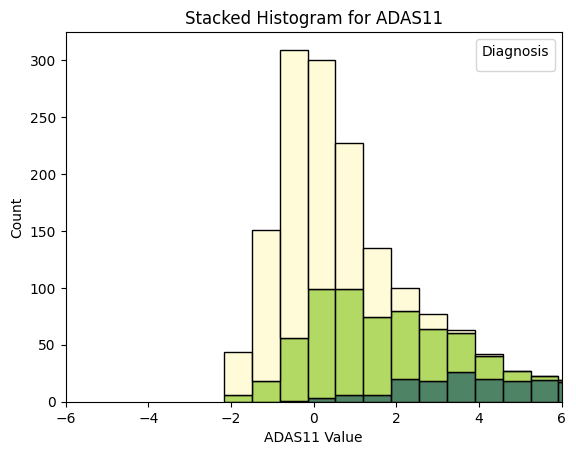

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/3336109719.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


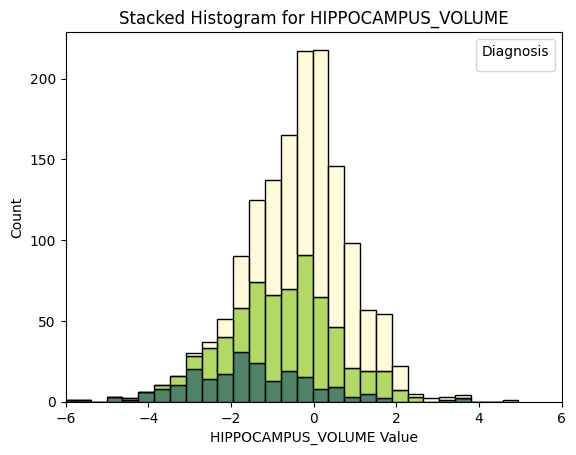

/var/folders/s8/x9wmskq97fv12b1hfqdfvybh0000gn/T/ipykernel_59504/3336109719.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Diagnosis')


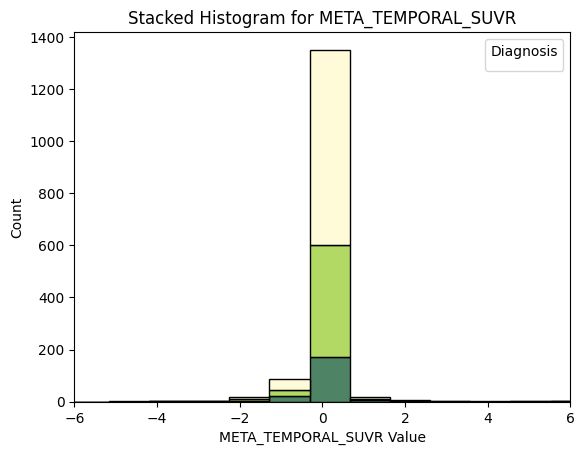

In [172]:
# Plot biomarker histograms check their distributions

for biomarker in selected_biomarkers:
    plt.figure()  # Creates a new figure for each plot
    sns.histplot(data=processed_data, x=biomarker, hue='DIAGNOSIS', bins=30, 
                multiple='stack', palette=diagnosis_palette)
    plt.title(f'Stacked Histogram for {biomarker}')
    plt.xlabel(f'{biomarker} Value')
    plt.ylabel('Count')
    plt.xlim(-6, 6)
    plt.legend(title='Diagnosis')
    plt.show()

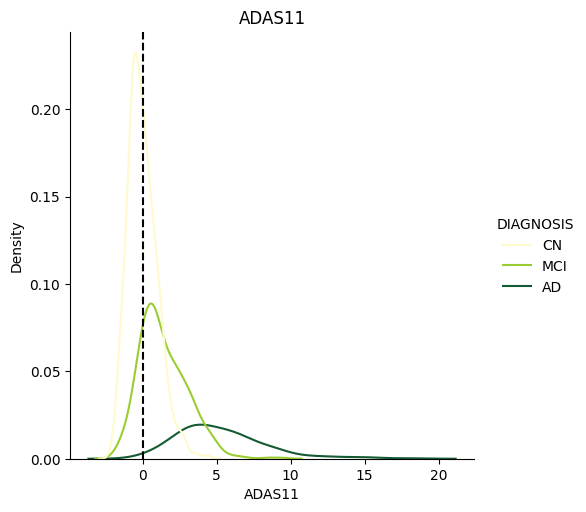

In [107]:
# First a quick look at the patient and control distribution for one of our biomarkers

# make a copy of our dataframe (we don't want to overwrite our original data)
zdata = pandas.DataFrame(processed_data,copy=True)

biomarker = selected_biomarkers[0]
sns.displot(data=zdata,x=biomarker,hue='DIAGNOSIS',kind='kde',palette=diagnosis_palette)
plt.title(biomarker)
plt.axvline(0,ls='--',c='black') # the 0 line *should* be the mean of the control distribution
plt.show()

# Prepare SuStaIn inputs

In [116]:
N = len(selected_biomarkers) # Number of biomarkers

SuStaInLabels = selected_biomarkers

Z_vals = np.array([[1,2,3] for _ in range(N)])     # Z-scores for each biomarker 
Z_max = np.array([5] * N)  # maximum z-score - set to 5 for each biomarker

In [140]:
# Prepare data for input to SuStaIn

# # First, let's see how many missing values we have in each biomarker
print("Number of missing values per biomarker:")
print(zdata[list(selected_biomarkers)].isnull().sum())

# Remove rows with any missing values in our biomarkers of interest
zdata = zdata.dropna(subset=list(selected_biomarkers))

print("\nShape after removing missing values:", zdata.shape)

# 1. First clean the data
zdata_clean = zdata.dropna(subset=list(selected_biomarkers))

# 2. Check the range of values
print("Data ranges:")
print(zdata_clean[list(selected_biomarkers)].describe())

# 3. Normalize the data to a reasonable range (e.g., z-scores)

# Create normalized version of the data
normalized_data = zdata_clean.copy()
for col in selected_biomarkers:
    normalized_data[col] = stats.zscore(zdata_clean[col])

# Add a small epsilon to prevent zeros
epsilon = 1e-10
normalized_data[list(selected_biomarkers)] = normalized_data[list(selected_biomarkers)].clip(lower=epsilon)

Number of missing values per biomarker:
ADAS11                0
HIPPOCAMPUS_VOLUME    0
META_TEMPORAL_SUVR    0
dtype: int64

Shape after removing missing values: (1486, 33)
Data ranges:
            ADAS11  HIPPOCAMPUS_VOLUME  META_TEMPORAL_SUVR
count  1486.000000         1486.000000         1486.000000
mean      1.198340            0.378699            6.022607
std       2.412804            1.270982          195.944558
min      -2.169489           -4.954199        -2147.652116
25%      -0.380983           -0.416184           -0.653656
50%       0.507046            0.282357            0.294934
75%       2.038114            1.156795            1.534672
max      18.059758            6.541805         4214.755972


In [141]:
# Input the settings for SuStaIn (the subtyping and staging algorithm)
N_startpoints = 25 # Recomended: 25
N_S_max = 1 # Number of subtypes
N_iterations_MCMC = int(1e4) # To start use int(1e4), increase this to 1e5 or 1e6
output_folder = os.path.join(os.getcwd(), 'WorkshopOutput')
dataset_name = 'WorkshopOutput'

# Initiate the SuStaIn object
sustain_input = pySuStaIn.ZscoreSustain(
                              normalized_data[selected_biomarkers].values,
                              Z_vals,
                              Z_max,
                              SuStaInLabels,
                              N_startpoints,
                              N_S_max, 
                              N_iterations_MCMC, 
                              output_folder, 
                              dataset_name, 
                              False)

# Run SuStaIn!

In [142]:
# Delete pickle file (SAVE ANY SIGNIFICANT RESULTS FIRST!)
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

In [143]:
# make the output directory if it's not already created
if not os.path.isdir(output_folder):
    os.mkdir(output_folder)

In [144]:
samples_sequence,   \
samples_f,          \
ml_subtype,         \
prob_ml_subtype,    \
ml_stage,           \
prob_ml_stage,      \
prob_subtype_stage  = sustain_input.run_sustain_algorithm()

Failed to find pickle file: /Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/notebooks/WorkshopOutput/pickle_files/WorkshopOutput_subtype0.pickle. Running SuStaIn model for 0 subtype.
Finding ML solution to 1 cluster problem
Overall ML likelihood is -7307.435664753967


MCMC Iteration: 100%|██████████| 10000/10000 [00:03<00:00, 2897.88it/s]


In [145]:
# Get model output from pickle file
s = N_S_max - 1 # Which subtype
pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

# Assess likelihood across MCMC samples
Use to assess the selections of z_vals for each biomarker. Use whichever combination of z_vals maximizes likelihood.

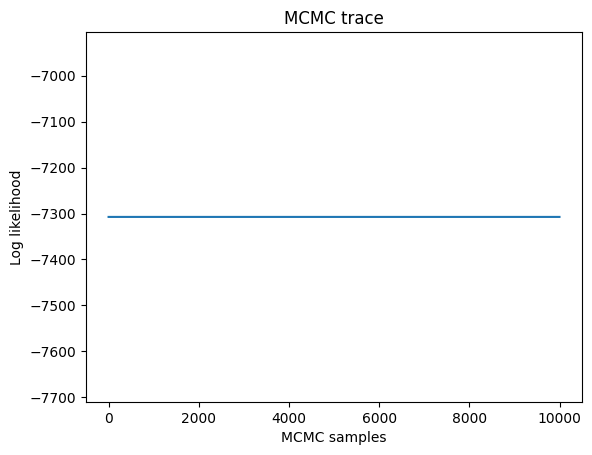

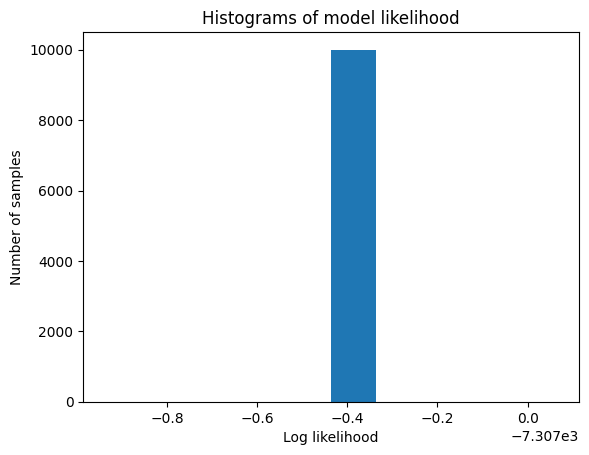

In [146]:
for s in range(N_S_max):
    # load pickle file (SuStaIn output) and get the sample log likelihood values
    pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
    pk = pandas.read_pickle(pickle_filename_s)
    samples_likelihood = pk["samples_likelihood"]
    
    # plot the values as a line plot
    plt.figure(0)
    plt.plot(range(N_iterations_MCMC), samples_likelihood, label="subtype" + str(s))
    #plt.legend(loc='upper right')
    plt.xlabel('MCMC samples')
    plt.ylabel('Log likelihood')
    plt.title('MCMC trace')
    
    # plot the values as a histogramp plot
    plt.figure(1)
    plt.hist(samples_likelihood, label="subtype" + str(s))
    #plt.legend(loc='upper right')
    plt.xlabel('Log likelihood')  
    plt.ylabel('Number of samples')  
    plt.title('Histograms of model likelihood')

# Stage individuals

In [147]:
# The SuStaIn output has everything we need. We'll use it to populate our dataframe.

pickle_filename_s = output_folder + '/pickle_files/' + dataset_name + '_subtype' + str(s) + '.pickle'
pk = pandas.read_pickle(pickle_filename_s)

for variable in ['ml_subtype', # the assigned subtype
                 'prob_ml_subtype', # the probability of the assigned subtype
                 'ml_stage', # the assigned stage 
                 'prob_ml_stage',]: # the probability of the assigned stage
    
    # add SuStaIn output to dataframe
    zdata.loc[:,variable] = pk[variable] 

for i in range(s):
    zdata.loc[:,'prob_S%s'%i] = pk['prob_subtype'][:,i]

zdata

,LONIUID,RID,VISCODE_x,SCANDATE,PROCESSDATE,IMAGE_RESOLUTION,qc_flag,TRACER,TRACER_SUVR_WARNING,update_stamp,...,PTETHCAT,PTRACCAT,AGE_AT_SCAN,ADAS11,HIPPOCAMPUS_VOLUME,META_TEMPORAL_SUVR,ml_subtype,prob_ml_subtype,ml_stage,prob_ml_stage
0,I1594604,21,init,2018-02-02,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,4,85.002053,-0.158089,-0.333452,1.215956,0.0,1.0,0.0,0.603624
1,I1596177,31,init,2018-04-24,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,5,90.310746,-1.594868,0.677056,-0.239392,0.0,1.0,0.0,0.568582
2,I1596172,31,y1,2019-04-23,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,5,91.307324,-1.639684,0.896525,-0.876995,0.0,1.0,0.0,0.542287
3,I1598898,56,init,2018-02-20,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,4,81.973990,-1.579745,0.257640,0.965635,0.0,1.0,0.0,0.603624
4,I1598985,56,y1,2019-01-10,2022-09-02,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,4,82.861054,0.179240,0.041200,6.010554,0.0,1.0,0.0,0.603624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1512,I1648618,7114,bl,2022-12-06,2023-05-26,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,4,65.842574,-1.332827,0.476783,0.422115,0.0,1.0,0.0,0.592211
1513,I10279040,7117,bl,2023-02-07,2023-12-08,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,4,69.267625,0.070977,0.326873,1.163861,0.0,1.0,0.0,0.603624
1514,I10239398,7121,bl,2023-05-10,2023-09-28,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,2.0,5,62.436687,0.259434,1.458200,-1.108785,0.0,1.0,0.0,0.474055
1515,I10298377,7123,bl,2023-05-18,2024-01-03,6mm,2,FTP,DO NOT COMPARE SUVRs ACROSS TRACERS,2024-04-03 12:57:55.0,...,1.0,6,80.459959,0.405942,1.429477,-1.464372,0.0,1.0,0.0,0.477550


In [148]:
# Save zdata to a new file for analysis (GO TO PROCESSING MODEL OUTPUT)
zdata.to_csv('/Users/robinsandell/Desktop/Raj Lab/EBM + Nexis/CODE EBM + Nexis/sustaln/SuStaIn/zdata/StaND + DNN/zdata-hippo,meta_roi_tau,adas11.csv')

In [150]:
zdata.ml_subtype.value_counts()
zdata.ml_stage.value_counts()

ml_stage
0.0    1194
1.0     146
2.0      79
3.0      36
4.0      24
5.0       4
9.0       3
Name: count, dtype: int64

As a sanity check, let's make sure all the "controls" were given assigned to low stages by SuStaIn

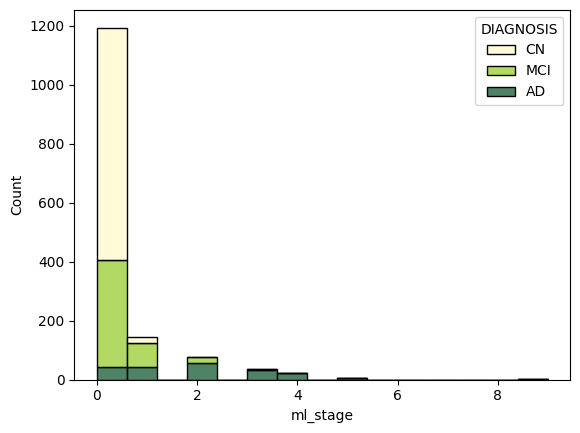

In [152]:
# Use clincial diagnostic categories as a rough way to assess the sucess of the model's stage assignments

sns.histplot(data=zdata, x='ml_stage', hue='DIAGNOSIS', bins=15, multiple='stack', palette=diagnosis_palette)
plt.show()